In [2]:
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
import torch
import torch.nn as nn

In [4]:
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [7]:
import numpy as np
from scipy.linalg import sqrtm
from torchvision.models.inception import inception_v3

In [8]:
!pip install medmnist torchvision tensorboard


In [9]:
pip install torch torchvision tensorboard scipy

Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib.pyplot as plt

In [11]:
import torch
import torch.nn.functional as F
from torchvision.models.inception import inception_v3
from torchvision import transforms
import numpy as np

In [12]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [13]:
!pip install medmnist

In [14]:
!pip install torchmetrics[image] torch-fidelity --quiet


In [15]:
import os
import medmnist
from medmnist import PneumoniaMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# Load MedMNIST directly from Kaggle dataset
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = PneumoniaMNIST(split="train", download=True, transform=data_transform)
test_dataset = PneumoniaMNIST(split="test", download=True, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [16]:
# Define Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),  # Output shape for MedMNIST
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

# Define Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x.view(-1, 28*28))

In [18]:
import torch

# Check if GPU is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Instantiate the Generator and Discriminator

latent_dim = 100

# Initialize separate generator and discriminator instances for each GAN variant
generator_LSGAN = Generator(latent_dim).to(device)
discriminator_LSGAN = Discriminator().to(device)

generator_WGAN = Generator(latent_dim).to(device)
discriminator_WGAN = Discriminator().to(device)

generator_WGAN_GP = Generator(latent_dim).to(device)
discriminator_WGAN_GP = Discriminator().to(device)


Evaluation Metrics: Inception Score, FID, Visual Inspection.

In [20]:
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.transforms.functional import to_pil_image

In [ ]:
def inception_score(generator, latent_dim, num_samples=5000, batch_size=50, splits=10):
    generator.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained Inception model
    inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
    inception_model.eval()
    

    transform = transforms.Compose([
        transforms.Resize((299, 299)),  
        transforms.ToTensor(),
    ])
  

    fake_images = [transform(to_pil_image(img.cpu())) for img in fake_images]


    preds = []
    for _ in range(num_samples // batch_size):
        z = torch.randn(batch_size, latent_dim).to(device)
        with torch.no_grad():
            fake_images = generator(z)
        
        # Convert to RGB if grayscale
        if fake_images.shape[1] == 1:
            fake_images = fake_images.repeat(1, 3, 1, 1)

        fake_images = [transform(img.cpu()) for img in fake_images]
        fake_images = torch.stack(fake_images).to(device)

        with torch.no_grad():
            logits = inception_model(fake_images)
            preds.append(F.softmax(logits, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    split_scores = []

    for k in np.array_split(preds, splits):
        kl_div = k * (np.log(k) - np.log(np.mean(k, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))

    return np.mean(split_scores), np.std(split_scores)

In [ ]:
# Function to compute Fréchet Inception Distance (FID)
def calculate_fid(real_images, fake_images):
    """Compute FID between real and generated images."""
    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)
    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))
    return np.real(fid)

Visual Inspection (Qualitative Evaluation)

In [21]:
def visualize_images(generator, latent_dim, num_samples=10):
    generator.eval()
    z = torch.randn(num_samples, latent_dim).to(next(generator.parameters()).device)

    with torch.no_grad():
        fake_images = generator(z).cpu()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(fake_images[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.show()

Function to display images during training cycles.

In [22]:
def display_images(images, epoch, gan_type):
    images = images.cpu().detach()
    grid = vutils.make_grid(images[:16], normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f"{gan_type} - Epoch {epoch}")
    plt.axis("off")
    plt.show()

In [23]:
def train_ls_gan(generator, discriminator, dataloader, epochs=50, latent_dim=100, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    criterion = nn.MSELoss()
    writer = SummaryWriter("runs/LS-GAN")
    
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.shape[0]
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(z)
            
            optimizer_D.zero_grad()
            real_preds = discriminator(real_images).squeeze()
            fake_preds = discriminator(fake_images.detach()).squeeze()
            d_loss = 0.5 * torch.mean((real_preds - 1) ** 2) + 0.5 * torch.mean(fake_preds ** 2)
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            fake_preds = discriminator(fake_images).squeeze()
            g_loss = 0.5 * torch.mean((fake_preds - 1) ** 2)
            g_loss.backward()
            optimizer_G.step()
            
        if epoch % 5 == 0:
            display_images(fake_images, epoch, "LS-GAN")
    
    writer.close()

In [24]:
def train_wgan_gp(generator, discriminator, dataloader, epochs=50, latent_dim=100, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    lambda_gp = 10
    
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.shape[0]
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(z)
            
            optimizer_D.zero_grad()
            real_preds = discriminator(real_images).squeeze()
            fake_preds = discriminator(fake_images.detach()).squeeze()
            
            epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
            interpolated = epsilon * real_images + (1 - epsilon) * fake_images.detach()
            interpolated.requires_grad_(True)
            interp_preds = discriminator(interpolated).squeeze()
            gradients = torch.autograd.grad(outputs=interp_preds, inputs=interpolated,
                                            grad_outputs=torch.ones_like(interp_preds),
                                            create_graph=True, retain_graph=True)[0]
            gradient_penalty = ((gradients.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()
            
            d_loss = -torch.mean(real_preds) + torch.mean(fake_preds) + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            fake_preds = discriminator(fake_images).squeeze()
            g_loss = -torch.mean(fake_preds)
            g_loss.backward()
            optimizer_G.step()
            
        if epoch % 5 == 0:
            display_images(fake_images, epoch, "WGAN-GP")

In [25]:

def train_wgan(generator, discriminator, dataloader, epochs=50, latent_dim=100, lr=0.0002):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for i, (real_images, _) in enumerate(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.shape[0]
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_images = generator(z)
            
            optimizer_D.zero_grad()
            real_preds = discriminator(real_images).squeeze()
            fake_preds = discriminator(fake_images.detach()).squeeze()
            d_loss = -torch.mean(real_preds) + torch.mean(fake_preds)
            d_loss.backward()
            optimizer_D.step()
            
            optimizer_G.zero_grad()
            fake_preds = discriminator(fake_images).squeeze()
            g_loss = -torch.mean(fake_preds)
            g_loss.backward()
            optimizer_G.step()
            
        if epoch % 5 == 0:
            display_images(fake_images, epoch, "WGAN")

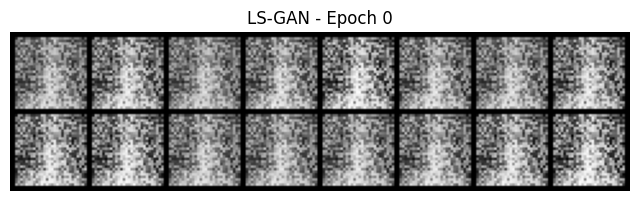

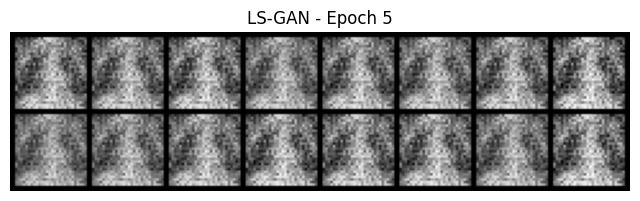

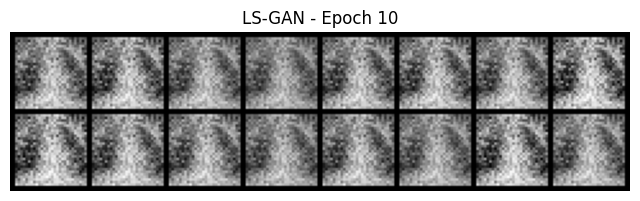

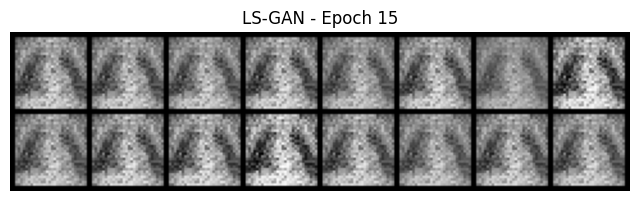

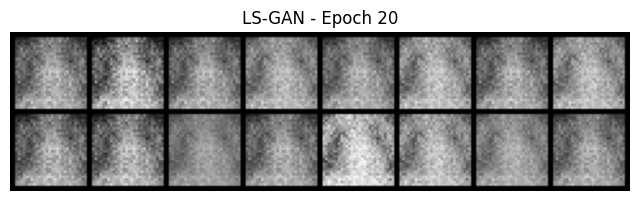

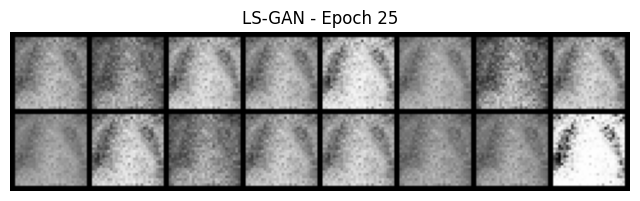

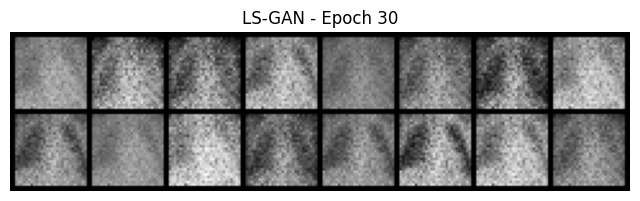

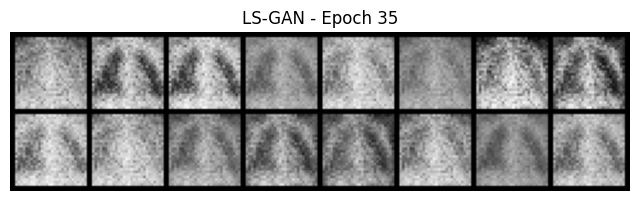

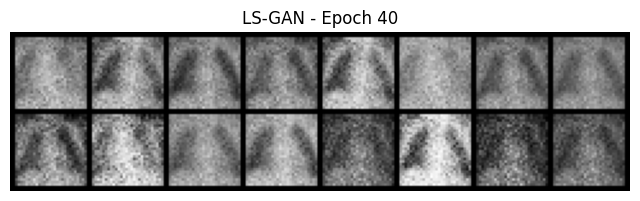

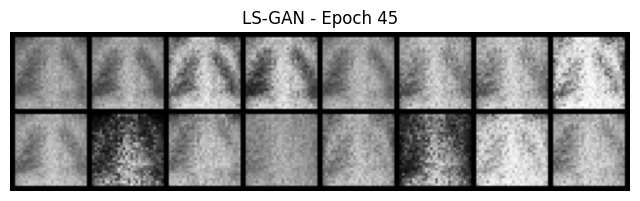

In [26]:
# Train each GAN variant
train_ls_gan(generator_LSGAN, discriminator_LSGAN, train_loader)

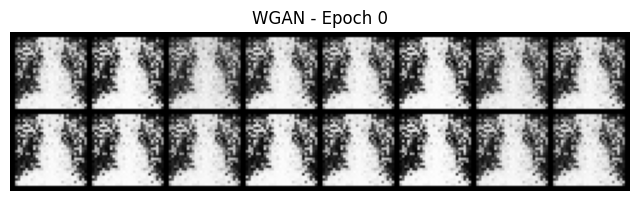

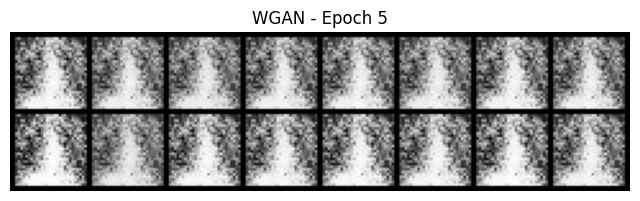

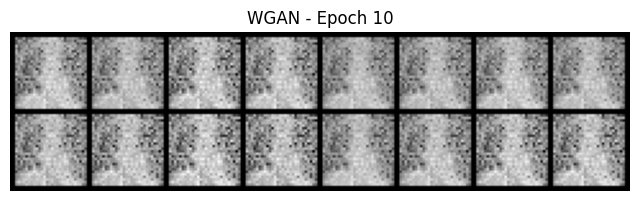

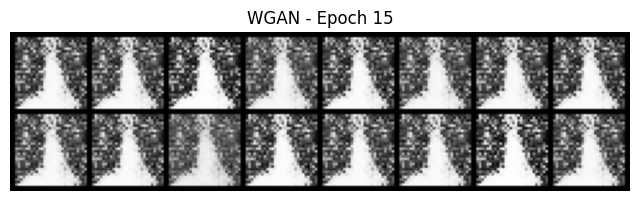

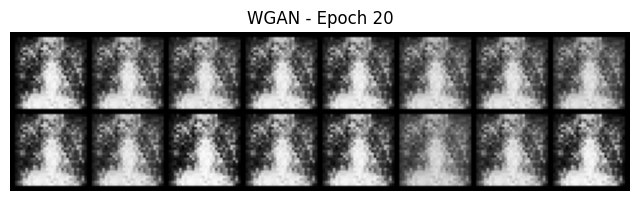

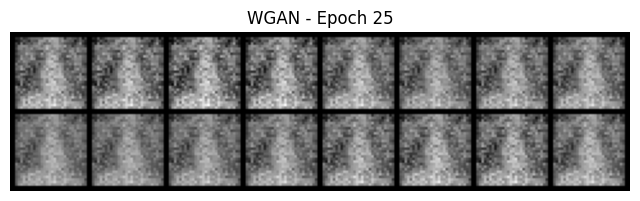

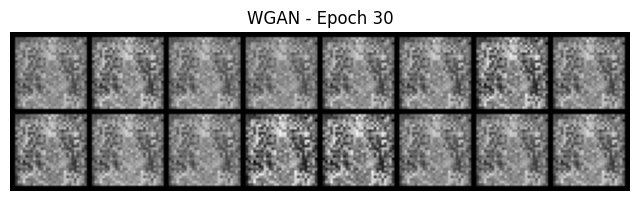

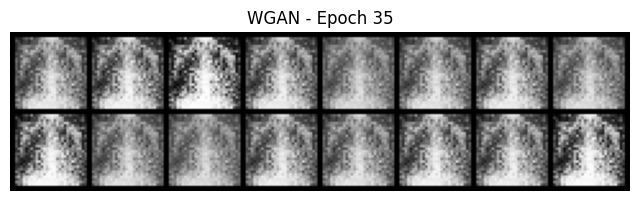

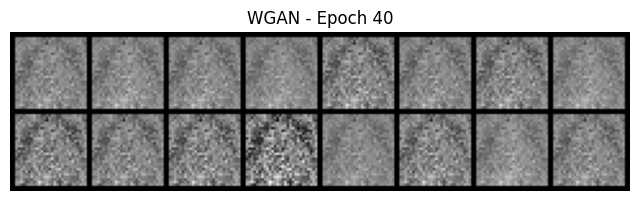

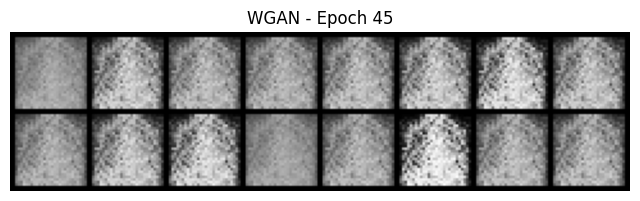

In [27]:
train_wgan(generator_WGAN, discriminator_WGAN, train_loader)

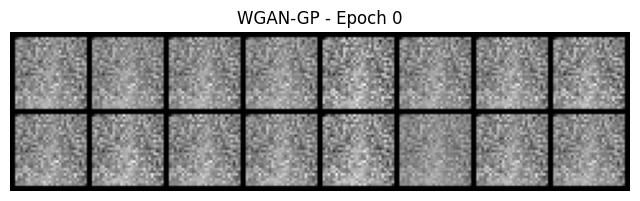

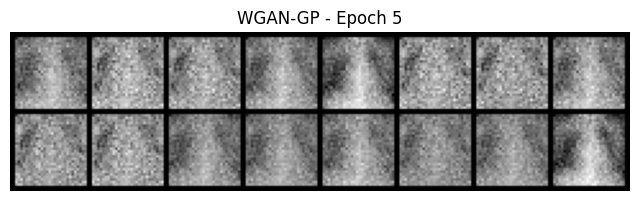

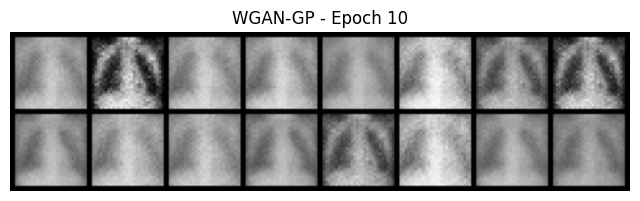

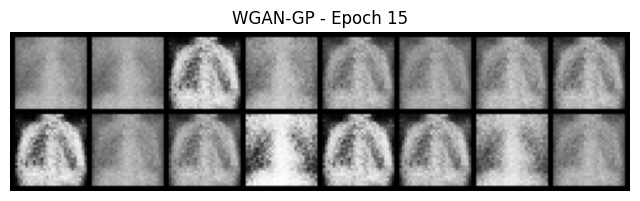

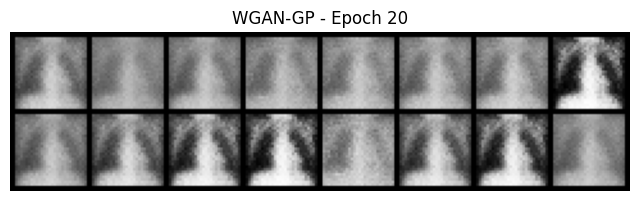

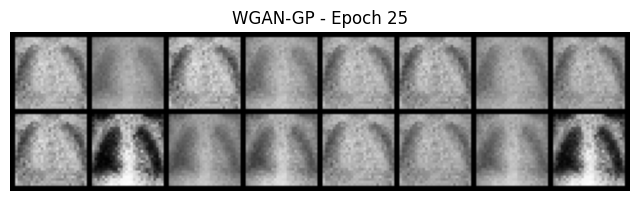

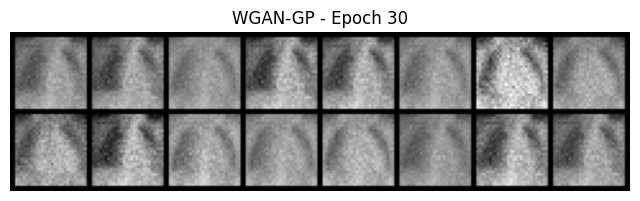

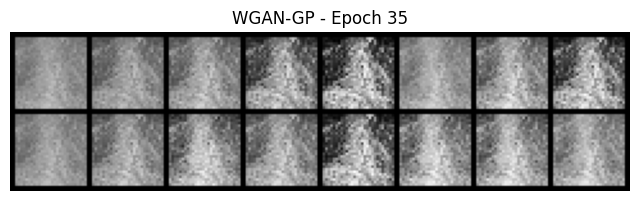

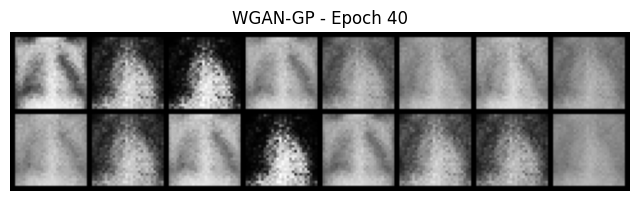

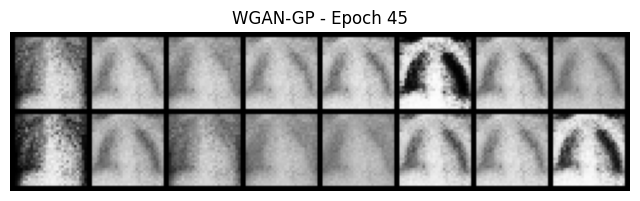

In [28]:
train_wgan_gp(generator_WGAN_GP, discriminator_WGAN_GP,train_loader)

Testing each GAN Model after training for 50 epochs, on the Test Set

LSGAN Results:


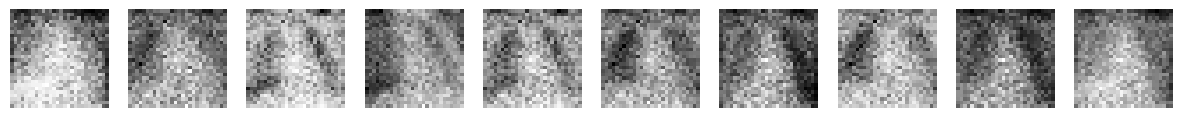

WGAN Results:


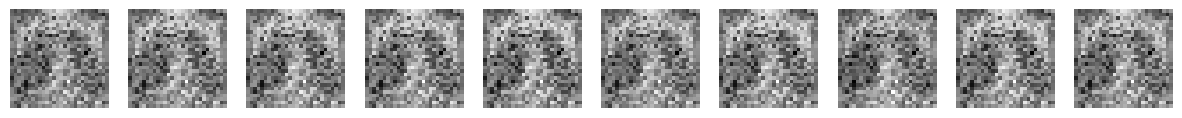

WGAN-GP Results:


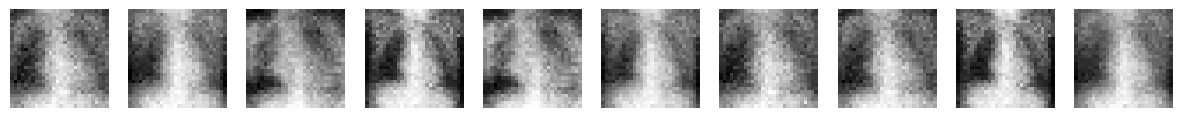

In [29]:
import torch
import matplotlib.pyplot as plt

fake_images_global = None

def generate_images(generator, latent_dim, num_samples=10):
    global fake_images_global  # Declare as global

    generator.eval()  # Set to evaluation mode

    # Generate random latent vectors
    z = torch.randn(num_samples, latent_dim).to(next(generator.parameters()).device)

    # Generate fake images
    with torch.no_grad():
        fake_images = generator(z)

    # Store in the global variable as a PyTorch tensor
    fake_images_global = fake_images.cpu().detach()

    # Convert to NumPy for visualization
    fake_images_numpy = fake_images_global.numpy()
    

    # Plot the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(fake_images_numpy[i].squeeze(), cmap="gray")
        ax.axis("off")

    plt.show()

# Set the latent dimension (should match what was used during training)
latent_dim = 100  

# Generate and visualize images for each trained GAN
print("LSGAN Results:")
generate_images(generator_LSGAN, latent_dim)

print("WGAN Results:")
generate_images(generator_WGAN, latent_dim)

print("WGAN-GP Results:")
generate_images(generator_WGAN_GP, latent_dim)


In [ ]:
def inception_score(generator, latent_dim, num_samples=5000, batch_size=50, splits=10):
    generator.eval()  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained Inception model
    inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
    inception_model.eval()

    transform = transforms.Compose([
        transforms.Resize((299, 299)),  
        transforms.ToTensor(),
    ])

    fake_images = [transform(to_pil_image(img.cpu())) for img in fake_images_global]
    
    preds = []
    for _ in range(num_samples // batch_size):
        z = torch.randn(batch_size, latent_dim).to(device)
        with torch.no_grad():
            fake_images = generator(z)
        
        # Convert to RGB if grayscale
        if fake_images.shape[1] == 1:
            fake_images = fake_images.repeat(1, 3, 1, 1)

        fake_images = [transform(img.cpu()) for img in fake_images]
        fake_images = torch.stack(fake_images).to(device)

        with torch.no_grad():
            logits = inception_model(fake_images)
            preds.append(F.softmax(logits, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    split_scores = []

    for k in np.array_split(preds, splits):
        kl_div = k * (np.log(k) - np.log(np.mean(k, axis=0, keepdims=True)))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))

    return np.mean(split_scores), np.std(split_scores)

In [ ]:
# Compute IS for each GAN
print("Inception Score (LSGAN):", inception_score(generator, latent_dim))
print("Inception Score (WGAN):", inception_score(generator, latent_dim))
print("Inception Score (WGAN-GP):", inception_score(generator, latent_dim))

In [30]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

In [31]:
# Function to generate and store fake images
def generate_fake_images(generator, latent_dim, num_samples=100):
    generator.eval()  # Set generator to evaluation mode

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Generate latent vectors
        fake_images = generator(z).cpu().detach()  # Generate images and move to CPU

    return fake_images

In [38]:
# Define inception_score function
def inception_score(images, device="cuda" if torch.cuda.is_available() else "cpu"):
    inception = InceptionScore(normalize=True).to(device)
    
    # Move images to the same device as the model
    images = images.to(device)
    
    return inception(images)

In [40]:
# Assuming real_images is a tensor of real samples
real_images = next(iter(train_loader))[0]  # Get a batch of real images
real_images = (real_images * 255).to(torch.uint8)

# Convert grayscale images to 3-channel RGB
real_images = real_images.repeat(1, 3, 1, 1)  # (batch, 1, H, W) → (batch, 3, H, W)


# Generate fake images for each GAN
fake_images_LSGAN = generate_fake_images(generator_LSGAN, latent_dim)
fake_images_LSGAN = (fake_images_LSGAN * 255).to(torch.uint8)
fake_images_LSGAN = fake_images_LSGAN.repeat(1, 3, 1, 1)

fake_images_WGAN = generate_fake_images(generator_WGAN, latent_dim)
fake_images_WGAN = (fake_images_WGAN * 255).to(torch.uint8)
fake_images_WGAN = fake_images_WGAN.repeat(1, 3, 1, 1)

fake_images_WGAN_GP = generate_fake_images(generator_WGAN_GP, latent_dim)
fake_images_WGAN_GP = (fake_images_WGAN_GP * 255).to(torch.uint8)
fake_images_WGAN_GP = fake_images_WGAN_GP.repeat(1, 3, 1, 1)


fid = FrechetInceptionDistance(feature=2048)  # Use feature=2048 for InceptionV3

# Compute FID for each GAN

#LSGAN
fid.update(real_images, real=True)
fid.update(fake_images_LSGAN, real=False)
fid_LSGAN = fid.compute().item()  # Compute FID for LSGAN
fid.reset()  # Reset before next calculation

#WGAN
fid.update(real_images, real=True)
fid.update(fake_images_WGAN, real=False)
fid_WGAN = fid.compute().item()  # Compute FID for WGAN
fid.reset()

#WGAN-GP
fid.update(real_images, real=True)
fid.update(fake_images_WGAN_GP, real=False)
fid_WGAN_GP = fid.compute().item()  # Compute FID for WGAN-GP
fid.reset()

# Compute Inception Score for each GAN
is_LSGAN, _ = inception_score(fake_images_LSGAN)  
is_WGAN, _ = inception_score(fake_images_WGAN)
is_WGAN_GP, _ = inception_score(fake_images_WGAN_GP)


# Print results
print(f"FID Scores: LSGAN = {fid_LSGAN}, WGAN = {fid_WGAN}, WGAN-GP = {fid_WGAN_GP}")
print(f"Inception Scores: LSGAN = {is_LSGAN}, WGAN = {is_WGAN}, WGAN-GP = {is_WGAN_GP}")



FID Scores: LSGAN = 244.07774353027344, WGAN = 364.8346862792969, WGAN-GP = 163.8689727783203
Inception Scores: LSGAN = 1.75304114818573, WGAN = 1.4697952270507812, WGAN-GP = 1.8742929697036743


LSGAN Results:


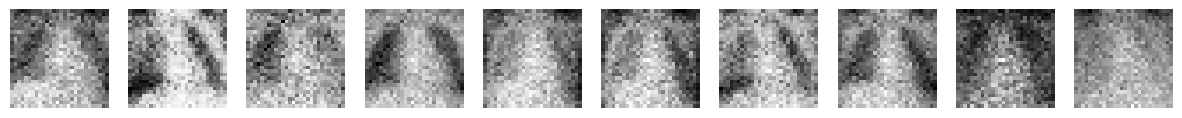

WGAN Results:


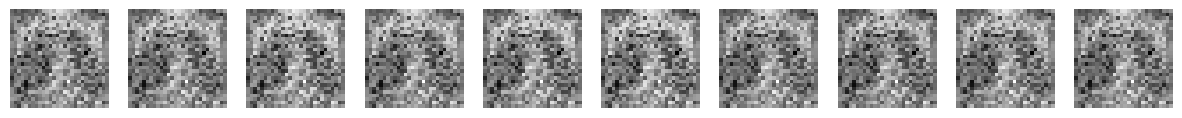

WGAN-GP Results:


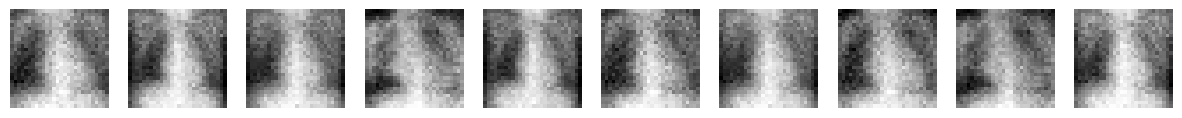

In [41]:
# Ensure generators are in evaluation mode
generator_LSGAN.eval()
generator_WGAN.eval()
generator_WGAN_GP.eval()

# Generate fake images for each model
def generate_images_and_store(generator, latent_dim, num_samples=10):
    # Generate random latent vectors
    z = torch.randn(num_samples, latent_dim).to(next(generator.parameters()).device)
    
    # Generate fake images
    with torch.no_grad():
        fake_images = generator(z)
    
    # Return the generated images
    return fake_images.cpu().detach()

# Generate fake images for each GAN
fake_images_LSGAN = generate_images_and_store(generator_LSGAN, latent_dim)
fake_images_WGAN = generate_images_and_store(generator_WGAN, latent_dim)
fake_images_WGAN_GP = generate_images_and_store(generator_WGAN_GP, latent_dim)

# Plot the images for each GAN variant
def plot_generated_images(fake_images, num_samples=10):
    # Convert to NumPy for visualization
    fake_images_numpy = fake_images.numpy()

    # Plot the images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(fake_images_numpy[i].squeeze(), cmap="gray")
        ax.axis("off")

    plt.show()

# Visualize images for each GAN variant
print("LSGAN Results:")
plot_generated_images(fake_images_LSGAN)

print("WGAN Results:")
plot_generated_images(fake_images_WGAN)

print("WGAN-GP Results:")
plot_generated_images(fake_images_WGAN_GP)


LSGAN Generated Images:


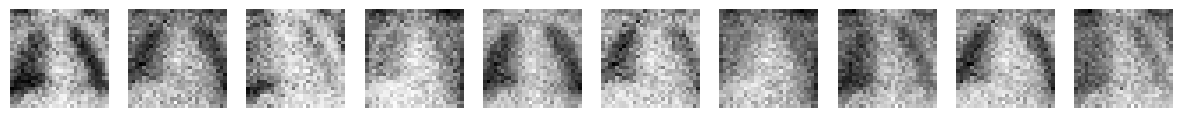

WGAN Generated Images:


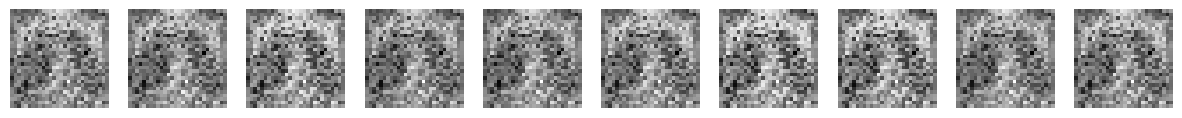

WGAN-GP Generated Images:


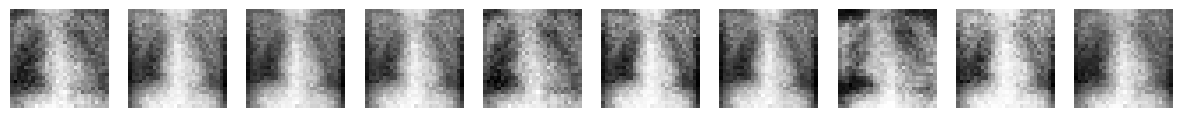

In [42]:
#Visual Inspection

# Visualize Images from Each GAN
print("LSGAN Generated Images:")
visualize_images(generator_LSGAN, latent_dim)

print("WGAN Generated Images:")
visualize_images(generator_WGAN, latent_dim)

print("WGAN-GP Generated Images:")
visualize_images(generator_WGAN_GP, latent_dim)

In [43]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

# Start TensorBoard
notebook.start("--logdir=runs")

<IPython.core.display.Javascript object>

In [46]:
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.utils

writer = SummaryWriter("runs/GAN_Comparison")

# Log Generated Images
def log_generated_images(generator, latent_dim, step, tag="Generated_Images"):
    generator.eval()
    z = torch.randn(10, latent_dim).to(next(generator.parameters()).device)

    with torch.no_grad():
        fake_images = generator(z).cpu()

    grid = torchvision.utils.make_grid(fake_images, normalize=True)
    writer.add_image(tag, grid, step)

# Log Losses (during training)
def log_losses(epoch, gen_loss, disc_loss, gan_type="LSGAN"):
    writer.add_scalar(f"{gan_type}/Generator_Loss", gen_loss, epoch)
    writer.add_scalar(f"{gan_type}/Discriminator_Loss", disc_loss, epoch)

# Log generated images for each GAN
log_generated_images(generator_LSGAN, latent_dim, step=0, tag="LSGAN_Images")
log_generated_images(generator_WGAN, latent_dim, step=0, tag="WGAN_Images")
log_generated_images(generator_WGAN_GP, latent_dim, step=0, tag="WGAN-GP_Images")

writer.close()


In [47]:
 """Run the Tensorboard at http://localhost:6006."""
!zip -r tensorboard_logs.zip runs
!unzip tensorboard_logs.zip -d logs/


  adding: runs/ (stored 0%)
  adding: runs/GAN_Comparison/ (stored 0%)
  adding: runs/GAN_Comparison/events.out.tfevents.1743602515.5b541aaa4a66.213.1 (deflated 9%)
  adding: runs/GAN_Comparison/events.out.tfevents.1743602546.5b541aaa4a66.213.3 (deflated 4%)
  adding: runs/GAN_Comparison/events.out.tfevents.1743602537.5b541aaa4a66.213.2 (deflated 5%)
  adding: runs/LS-GAN/ (stored 0%)
  adding: runs/LS-GAN/events.out.tfevents.1743600804.5b541aaa4a66.213.0 (deflated 9%)
  adding: runs/LS-GAN/events.out.tfevents.1743598269.5b541aaa4a66.31.2 (deflated 9%)
  adding: runs/LS-GAN/events.out.tfevents.1743598214.5b541aaa4a66.31.1 (deflated 9%)
  adding: runs/LS-GAN/events.out.tfevents.1743598025.5b541aaa4a66.31.0 (deflated 9%)
  adding: runs/LS-GAN/events.out.tfevents.1743599220.5b541aaa4a66.142.0 (deflated 9%)
Archive:  tensorboard_logs.zip
   creating: logs/runs/
   creating: logs/runs/GAN_Comparison/
  inflating: logs/runs/GAN_Comparison/events.out.tfevents.1743602515.5b541aaa4a66.213.1  
 

In [48]:
!ls -lh


total 100K
drwxr-xr-x 3 root root 4.0K Apr  2 14:02 logs
drwxr-xr-x 4 root root 4.0K Apr  2 14:01 runs
-rw-r--r-- 1 root root  92K Apr  2 14:02 tensorboard_logs.zip


In [49]:
!pip install tensorboard


In [50]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard


In [51]:
%tensorboard --logdir /kaggle/working/logs/runs


<IPython.core.display.Javascript object>

In [52]:
!ls -lh /kaggle/working/logs/runs/GAN_Comparison
!ls -lh /kaggle/working/logs/runs/LS-GAN


total 104K
-rw-r--r-- 1 root root  88 Apr  2 14:01 events.out.tfevents.1743602515.5b541aaa4a66.213.1
-rw-r--r-- 1 root root 49K Apr  2 14:02 events.out.tfevents.1743602537.5b541aaa4a66.213.2
-rw-r--r-- 1 root root 46K Apr  2 14:02 events.out.tfevents.1743602546.5b541aaa4a66.213.3
total 20K
-rw-r--r-- 1 root root 88 Apr  2 12:47 events.out.tfevents.1743598025.5b541aaa4a66.31.0
-rw-r--r-- 1 root root 88 Apr  2 12:50 events.out.tfevents.1743598214.5b541aaa4a66.31.1
-rw-r--r-- 1 root root 88 Apr  2 12:51 events.out.tfevents.1743598269.5b541aaa4a66.31.2
-rw-r--r-- 1 root root 88 Apr  2 13:07 events.out.tfevents.1743599220.5b541aaa4a66.142.0
-rw-r--r-- 1 root root 88 Apr  2 13:33 events.out.tfevents.1743600804.5b541aaa4a66.213.0


In [53]:
!zip -r tensorboard_logs.zip /kaggle/working/logs/runs


  adding: kaggle/working/logs/runs/ (stored 0%)
  adding: kaggle/working/logs/runs/GAN_Comparison/ (stored 0%)
  adding: kaggle/working/logs/runs/GAN_Comparison/events.out.tfevents.1743602515.5b541aaa4a66.213.1 (deflated 9%)
  adding: kaggle/working/logs/runs/GAN_Comparison/events.out.tfevents.1743602546.5b541aaa4a66.213.3 (deflated 4%)
  adding: kaggle/working/logs/runs/GAN_Comparison/events.out.tfevents.1743602537.5b541aaa4a66.213.2 (deflated 5%)
  adding: kaggle/working/logs/runs/LS-GAN/ (stored 0%)
  adding: kaggle/working/logs/runs/LS-GAN/events.out.tfevents.1743600804.5b541aaa4a66.213.0 (deflated 9%)
  adding: kaggle/working/logs/runs/LS-GAN/events.out.tfevents.1743598269.5b541aaa4a66.31.2 (deflated 9%)
  adding: kaggle/working/logs/runs/LS-GAN/events.out.tfevents.1743598214.5b541aaa4a66.31.1 (deflated 9%)
  adding: kaggle/working/logs/runs/LS-GAN/events.out.tfevents.1743598025.5b541aaa4a66.31.0 (deflated 9%)
  adding: kaggle/working/logs/runs/LS-GAN/events.out.tfevents.174359922

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit
